In [1]:


import SimpleITK as sitk
import numpy as np
import cv2
import os
import random
import shutil
from ultralytics import YOLO

import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import random
import pandas as pd



In [28]:
train_results = pd.read_csv('../radiological_gradings.csv')
train_results = train_results.loc[:, ['Patient','IVD label','Pfirrman grade']]
train_results


pfirrman_map = {
    (row.Patient, row["IVD label"]): row["Pfirrman grade"]
    for _, row in train_results.iterrows()
}


In [29]:
pfirrman_map

{(np.int64(1), np.int64(1)): np.int64(3),
 (np.int64(1), np.int64(2)): np.int64(3),
 (np.int64(1), np.int64(3)): np.int64(3),
 (np.int64(1), np.int64(4)): np.int64(4),
 (np.int64(1), np.int64(5)): np.int64(4),
 (np.int64(1), np.int64(6)): np.int64(4),
 (np.int64(1), np.int64(7)): np.int64(4),
 (np.int64(2), np.int64(1)): np.int64(4),
 (np.int64(2), np.int64(2)): np.int64(4),
 (np.int64(2), np.int64(3)): np.int64(3),
 (np.int64(2), np.int64(4)): np.int64(4),
 (np.int64(2), np.int64(5)): np.int64(4),
 (np.int64(2), np.int64(6)): np.int64(4),
 (np.int64(3), np.int64(1)): np.int64(4),
 (np.int64(3), np.int64(2)): np.int64(3),
 (np.int64(3), np.int64(3)): np.int64(4),
 (np.int64(3), np.int64(4)): np.int64(4),
 (np.int64(3), np.int64(5)): np.int64(3),
 (np.int64(3), np.int64(6)): np.int64(3),
 (np.int64(4), np.int64(1)): np.int64(3),
 (np.int64(4), np.int64(2)): np.int64(3),
 (np.int64(4), np.int64(3)): np.int64(5),
 (np.int64(4), np.int64(4)): np.int64(2),
 (np.int64(4), np.int64(5)): np.in

In [30]:
output_base = "PFIRRMANN_dataset"

def make_dirs(split):
    for g in [1,2,3,4,5]:
        os.makedirs(os.path.join(output_base, split, f"grade_{g}"), exist_ok=True)

make_dirs("train")
make_dirs("val")


In [31]:
def extract_and_resize_disc(img, mask, disc_id, size=128):
    binary = (mask == disc_id).astype(np.uint8)
    if binary.sum() == 0:
        return None

    ys, xs = np.where(binary)
    y_min, y_max = ys.min(), ys.max()
    x_min, x_max = xs.min(), xs.max()

    disc = img[y_min:y_max+1, x_min:x_max+1]

    if disc.size == 0:
        return None

    disc = normalize_to_jpg(disc)
    disc = cv2.resize(disc, (size, size), interpolation=cv2.INTER_LINEAR)
    return disc


def normalize_to_jpg(img_slice):
    img_min = np.min(img_slice)
    img_max = np.max(img_slice)

    if img_max == img_min:
        return np.zeros_like(img_slice, dtype=np.uint8)

    img_norm = 255.0 * (img_slice - img_min) / (img_max - img_min)
    return img_norm.astype(np.uint8)

In [32]:
patients = sorted(train_results["Patient"].unique())
random.seed(42)
random.shuffle(patients)

split = int(0.8 * len(patients))
train_patients = set(patients[:split])
val_patients = set(patients[split:])

In [33]:
base_dir = '../'
img_dir = os.path.join(base_dir, 'images')
mask_dir = os.path.join(base_dir, 'masks')


files = sorted([f for f in os.listdir(img_dir) if f.endswith("t2.mha")])

for filename in files:
    patient = int(filename.split("_")[0])

    split = "train" if patient in train_patients else "val"

    img_path = os.path.join(img_dir, filename)
    mask_path = os.path.join(mask_dir, filename)
    if not os.path.exists(mask_path):
        continue

    sitk_img = sitk.ReadImage(img_path)
    sitk_mask = sitk.ReadImage(mask_path)

    arr_img = sitk.GetArrayFromImage(sitk_img)
    arr_mask = sitk.GetArrayFromImage(sitk_mask)

    mid = arr_img.shape[2] // 2
    img_slice = np.flipud(arr_img[:, :, mid])
    mask_slice = np.flipud(arr_mask[:, :, mid])

    for disc_id in np.unique(mask_slice):
        if disc_id == 0:
            continue

        key = (patient, int(disc_id))
        if key not in pfirrman_map:
            continue

        grade = pfirrman_map[key]

        disc_img = extract_and_resize_disc(img_slice, mask_slice, disc_id)
        if disc_img is None:
            continue

        out_name = f"{patient}_disc{disc_id}.jpg"
        out_path = os.path.join(
            output_base,
            split,
            f"grade_{grade}",
            out_name
        )

        cv2.imwrite(out_path, disc_img)


KeyboardInterrupt: 

In [19]:
def bounding_box(mask_slice, label_id, img_w, img_h):
    y_indices, x_indices = np.where(mask_slice == label_id)
    
    if len(x_indices) == 0 or len(y_indices) == 0:
        return None

    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)

    x_center = (x_min + x_max) / 2.0 / img_w
    y_center = (y_min + y_max) / 2.0 / img_h
    bbox_w = (x_max - x_min) / img_w
    bbox_h = (y_max - y_min) / img_h

    return (x_center, y_center, bbox_w, bbox_h)

In [82]:
import os
import random
import numpy as np
import cv2
import SimpleITK as sitk

# ------------------------------------------------------
# Ścieżki
# ------------------------------------------------------
base_dir = '../'
img_dir = os.path.join(base_dir, 'images')
mask_dir = os.path.join(base_dir, 'masks')

output_base = "PFIRRMANN_dataset"

# Tworzymy foldery dla stopni Pfirrmann
for split in ["train", "val"]:
    for grade in [1,2,3,4,5]:
        path = os.path.join(output_base, split, f"grade_{grade}")
        os.makedirs(path, exist_ok=True)

LABELS_MAP = { 201: 1, 202: 2, 203: 3, 204: 4, 205: 5, 206: 6, 207: 7 }

# ------------------------------------------------------
# Funkcje pomocnicze
# ------------------------------------------------------
def normalize_and_resize(img, size=128):
    """Normalizacja do [0,255] i resize na size x size"""
    img_min, img_max = img.min(), img.max()
    if img_max == img_min:
        img_norm = np.zeros_like(img, dtype=np.uint8)
    else:
        img_norm = 255.0 * (img - img_min) / (img_max - img_min)
        img_norm = img_norm.astype(np.uint8)
    img_resized = cv2.resize(img_norm, (size, size))
    return img_resized

def extract_disc(img_slice, mask_slice, disc_id, size=128):
    ys, xs = np.where(mask_slice == disc_id)
    if len(xs) == 0:
        return None
    x_min, x_max = xs.min(), xs.max()
    y_min, y_max = ys.min(), ys.max()
    disc_crop = img_slice[y_min:y_max+1, x_min:x_max+1]
    return normalize_and_resize(disc_crop, size=size)

# ------------------------------------------------------
# Podział pacjentów na train/val
# ------------------------------------------------------
patients = sorted(set([p for (p,d) in pfirrman_map.keys()]))
random.seed(42)
random.shuffle(patients)
split_idx = int(0.8 * len(patients))
train_patients = set(patients[:split_idx])
val_patients = set(patients[split_idx:])

# ------------------------------------------------------
# Główna pętla przetwarzania
# ------------------------------------------------------
files = sorted([f for f in os.listdir(img_dir) if f.endswith("t2.mha")])

for filename in files:
    patient_id = int(filename.split("_")[0])
    split = "train" if patient_id in train_patients else "val"
    
    img_path = os.path.join(img_dir, filename)
    mask_path = os.path.join(mask_dir, filename)
    if not os.path.exists(mask_path):
        continue

    try:
        # Wczytanie całego obrazu i maski
        arr_img = sitk.GetArrayFromImage(sitk.ReadImage(img_path))
        arr_mask = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))

        # Środkowe slice’y

        grade = pfirrman_map.get((patient_id, int(disc_id)), "BRAK")
        print(f"Dysk {disc_id}, Pfirrmann grade: {grade}")

        mid = arr_img.shape[2] // 2
        slices_to_take = [mid-1, mid, mid+1]

        for s_idx in slices_to_take:
            img_slice = np.flipud(arr_img[:, :, s_idx])
            mask_slice = np.flipud(arr_mask[:, :, s_idx])

            for disc_id in np.unique(mask_slice):
                if disc_id < 200:  # ignorujemy tło
                    continue

                grade = pfirrman_map.get((patient_id, int(LABELS_MAP[disc_id])))
                if grade is None:
                    continue  # brak Pfirrmann grade

                # Wycinamy, normalizujemy i resize do 128x128
                disc_crop = extract_disc(img_slice, mask_slice, disc_id)
                if disc_crop is None:
                    continue

                # Zapis do folderu wg Pfirrmann
                out_name = f"{filename.replace('.mha','')}_s{s_idx}_disc{disc_id}.jpg"
                out_path = os.path.join(output_base, split, f"grade_{grade}", out_name)
                cv2.imwrite(out_path, disc_crop)

    except Exception as e:
        print(f"Error {filename}: {e}")

print("Data generation complete. Wszystkie dyski są po normalizacji i resize do 128x128.")


Dysk 203, Pfirrmann grade: BRAK
Error 100_t2.mha: np.int16(208)
Dysk 208, Pfirrmann grade: BRAK
Dysk 206, Pfirrmann grade: BRAK
Dysk 207, Pfirrmann grade: BRAK
Dysk 207, Pfirrmann grade: BRAK
Dysk 207, Pfirrmann grade: BRAK
Dysk 207, Pfirrmann grade: BRAK
Dysk 207, Pfirrmann grade: BRAK
Dysk 207, Pfirrmann grade: BRAK
Dysk 207, Pfirrmann grade: BRAK
Dysk 206, Pfirrmann grade: BRAK
Dysk 206, Pfirrmann grade: BRAK
Dysk 206, Pfirrmann grade: BRAK
Dysk 207, Pfirrmann grade: BRAK
Dysk 207, Pfirrmann grade: BRAK
Dysk 206, Pfirrmann grade: BRAK
Error 118_t2.mha: np.int16(208)
Dysk 208, Pfirrmann grade: BRAK
Error 11_t2.mha: np.int16(208)
Dysk 208, Pfirrmann grade: BRAK
Dysk 207, Pfirrmann grade: BRAK
Dysk 206, Pfirrmann grade: BRAK
Dysk 206, Pfirrmann grade: BRAK
Error 123_t2.mha: np.int16(208)
Dysk 208, Pfirrmann grade: BRAK
Dysk 206, Pfirrmann grade: BRAK
Dysk 207, Pfirrmann grade: BRAK
Dysk 205, Pfirrmann grade: BRAK
Dysk 203, Pfirrmann grade: BRAK
Dysk 206, Pfirrmann grade: BRAK
Dysk 207,

In [81]:
pfirrman_map.get((patient_id, int(LABELS_MAP[disc_id])))

np.int64(2)

In [49]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import SimpleITK as sitk

patient_id = 237
img_path = f"../images/{patient_id}_t2.mha"
mask_path = f"../masks/{patient_id}_t2.mha"

sitk_img = sitk.ReadImage(img_path)
sitk_mask = sitk.ReadImage(mask_path)

arr_img = sitk.GetArrayFromImage(sitk_img)  # shape: [H, W, slices]
arr_mask = sitk.GetArrayFromImage(sitk_mask)

print("Obraz:", arr_img.shape, "Maska:", arr_mask.shape)


Obraz: (495, 516, 18) Maska: (495, 516, 18)


In [60]:
def show_disc(img_slice, mask_slice, disc_id, size=128):
    ys, xs = np.where(mask_slice == disc_id)
    if len(xs) == 0:
        print(f"Dysk {disc_id} nie występuje w tym slice.")
        return

    x_min, x_max = xs.min(), xs.max()
    y_min, y_max = ys.min(), ys.max()

    # 1️⃣ wycięty dysk
    disc_crop = img_slice[y_min:y_max+1, x_min:x_max+1]

    # 2️⃣ normalizacja do [0,255]
    disc_norm = 255.0 * (disc_crop - disc_crop.min()) / (disc_crop.max() - disc_crop.min() + 1e-6)
    disc_norm = disc_norm.astype(np.uint8)

    # 3️⃣ resize do 128x128
    disc_resized = cv2.resize(disc_norm, (size, size))

    # 4️⃣ oryginalny slice z bbox
    img_rgb = cv2.cvtColor(cv2.normalize(img_slice, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8), cv2.COLOR_GRAY2BGR)
    cv2.rectangle(img_rgb, (x_min, y_min), (x_max, y_max), (0,255,0), 2)

    # 5️⃣ Wyświetlenie
    plt.figure(figsize=(15,5))

    plt.subplot(1,3,1)
    plt.title(f"Slice z bbox dysku {disc_id}")
    plt.imshow(img_rgb, cmap='gray')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title(f"Wycięty dysk")
    plt.imshow(disc_norm, cmap='gray')
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title(f"Dysk 128x128 (model input)")
    plt.imshow(disc_resized, cmap='gray')
    plt.axis('off')

    plt.show()



--- Slice 8 ---
Dysk 201, Pfirrmann grade: BRAK


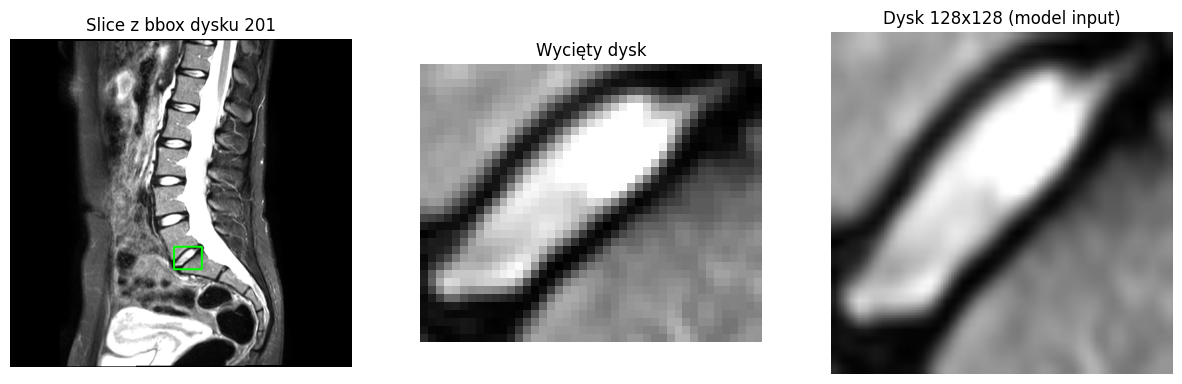

Dysk 202, Pfirrmann grade: BRAK


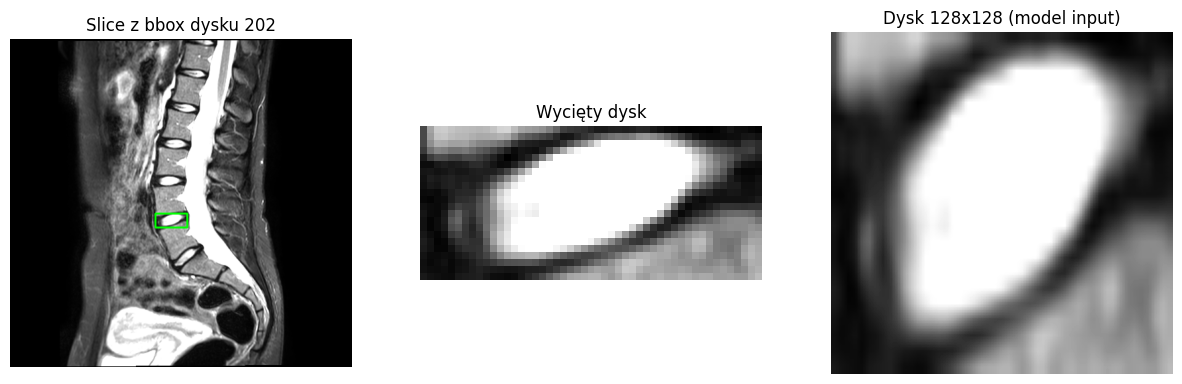

Dysk 203, Pfirrmann grade: BRAK


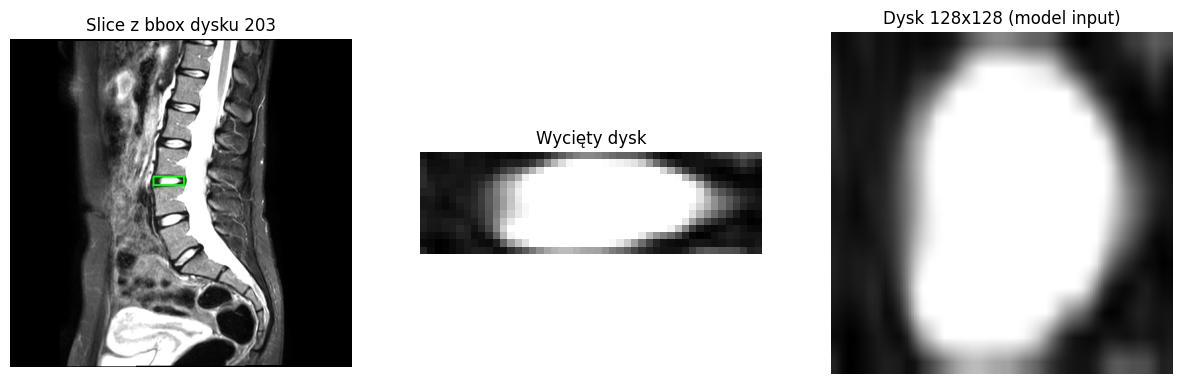

Dysk 204, Pfirrmann grade: BRAK


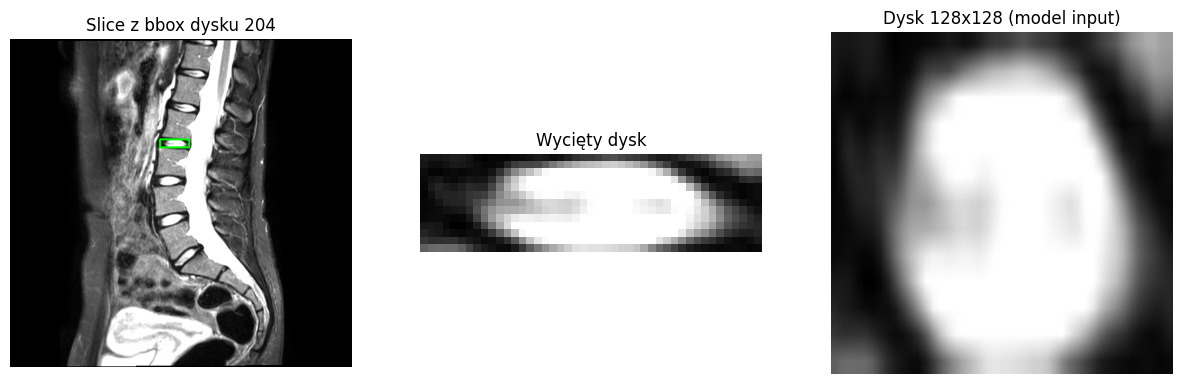

Dysk 205, Pfirrmann grade: BRAK


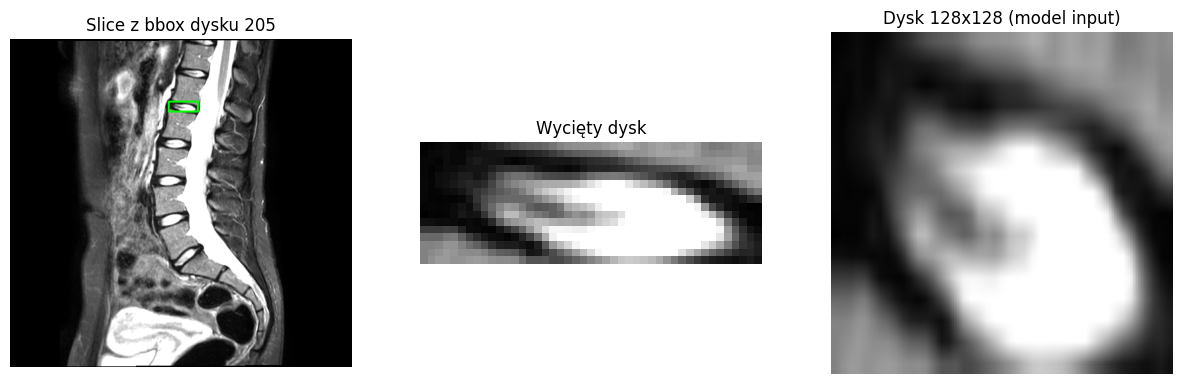

Dysk 206, Pfirrmann grade: BRAK


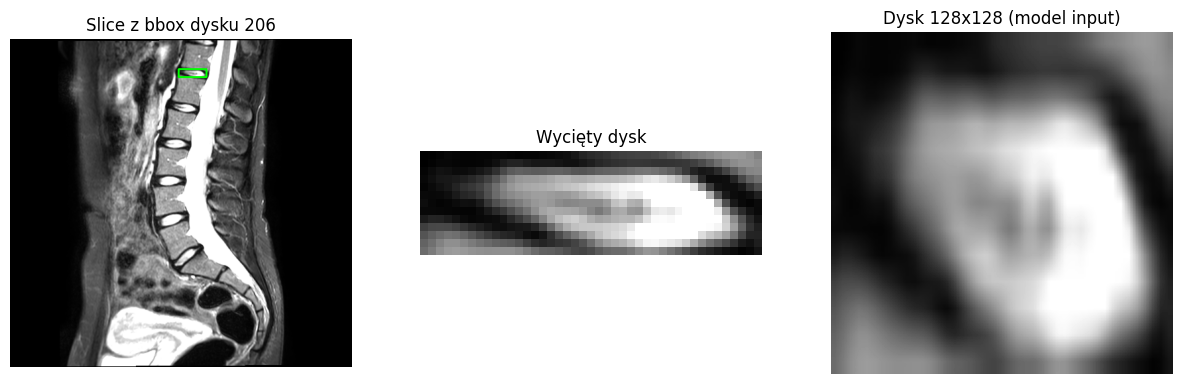


--- Slice 9 ---
Dysk 201, Pfirrmann grade: BRAK


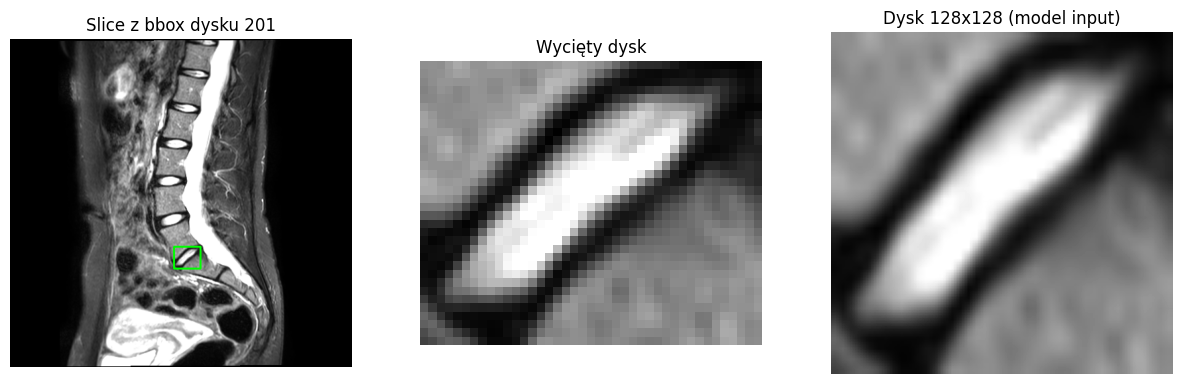

Dysk 202, Pfirrmann grade: BRAK


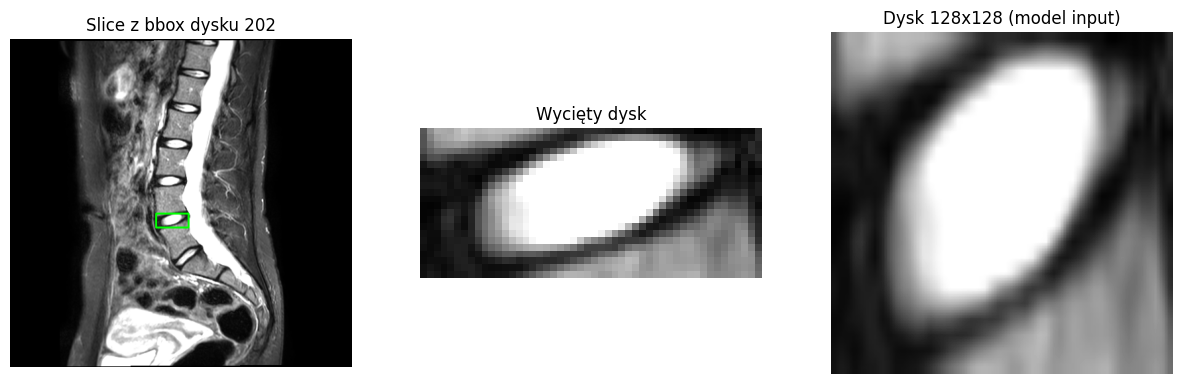

Dysk 203, Pfirrmann grade: BRAK


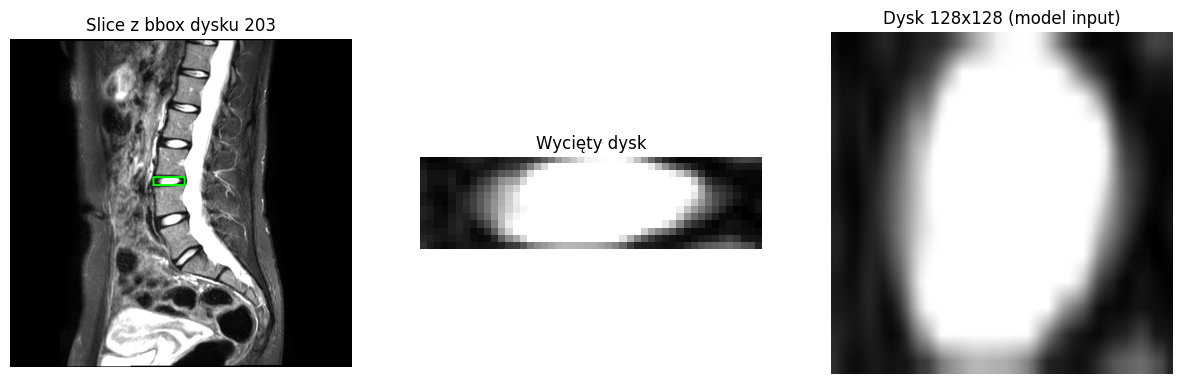

Dysk 204, Pfirrmann grade: BRAK


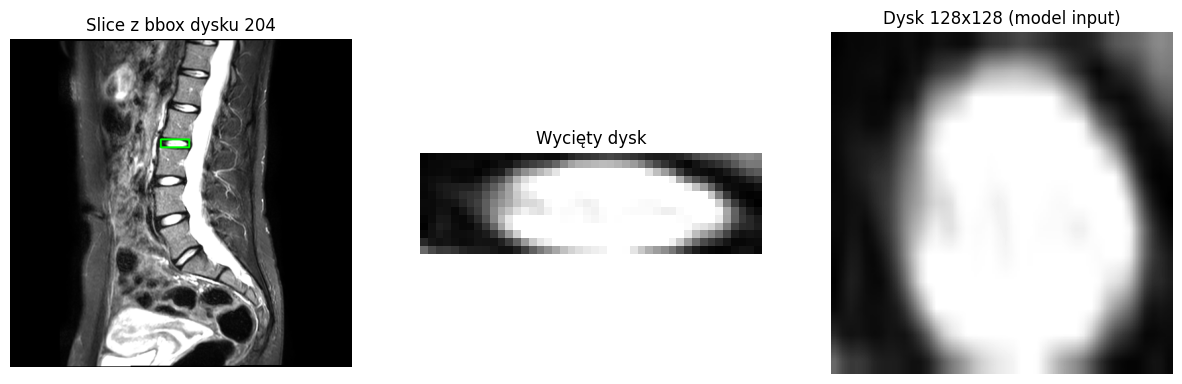

Dysk 205, Pfirrmann grade: BRAK


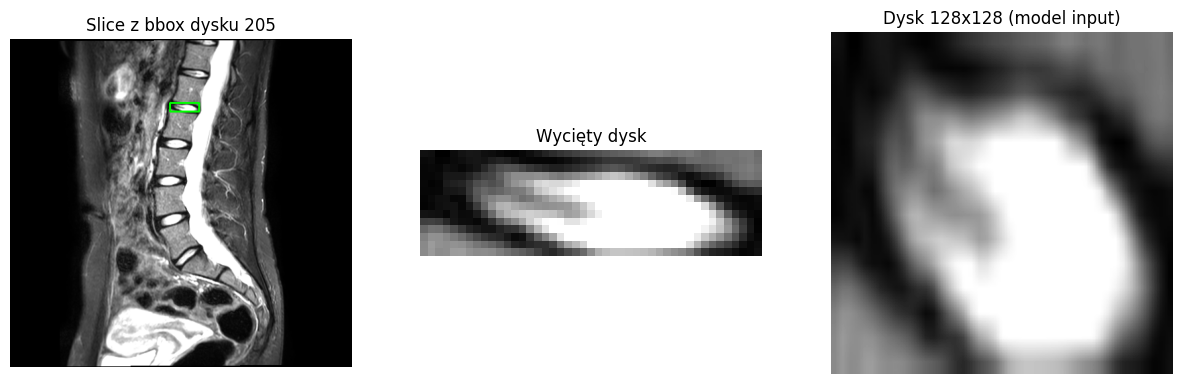

Dysk 206, Pfirrmann grade: BRAK


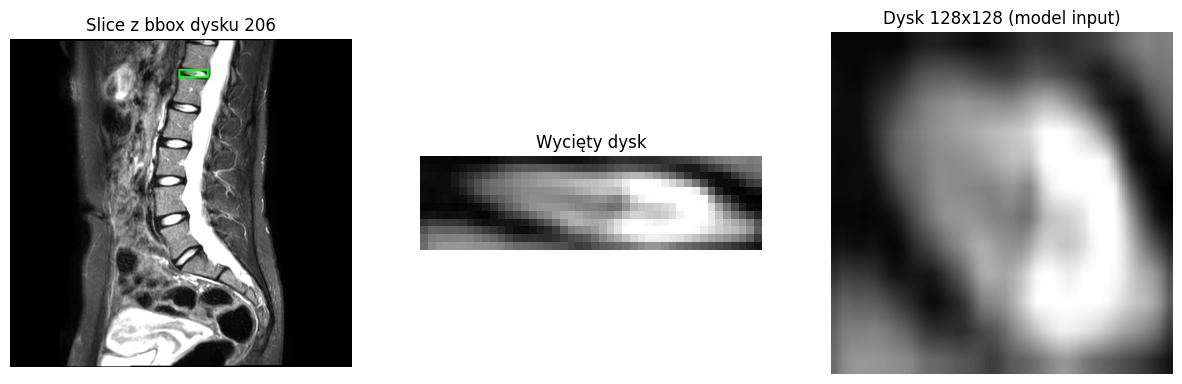


--- Slice 10 ---
Dysk 201, Pfirrmann grade: BRAK


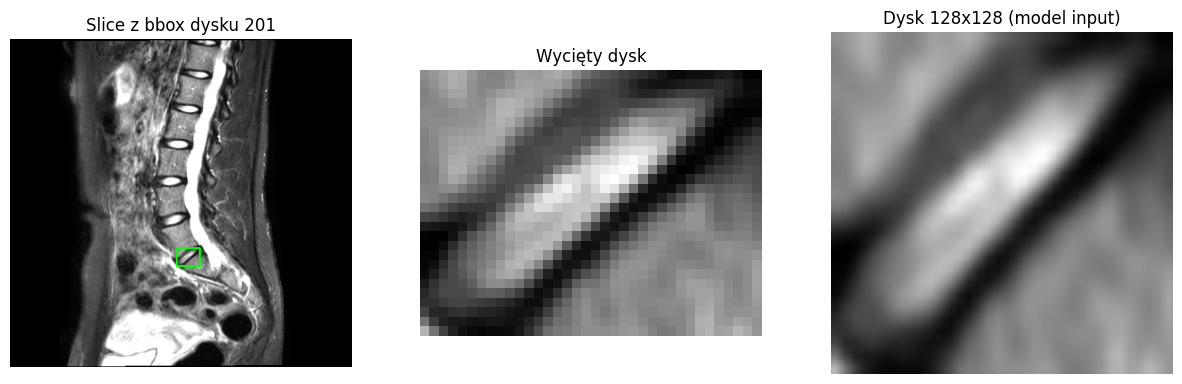

Dysk 202, Pfirrmann grade: BRAK


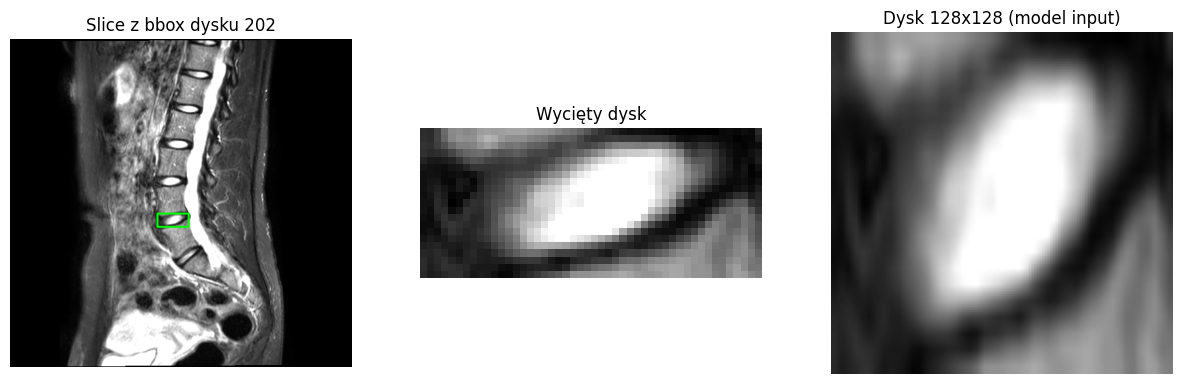

Dysk 203, Pfirrmann grade: BRAK


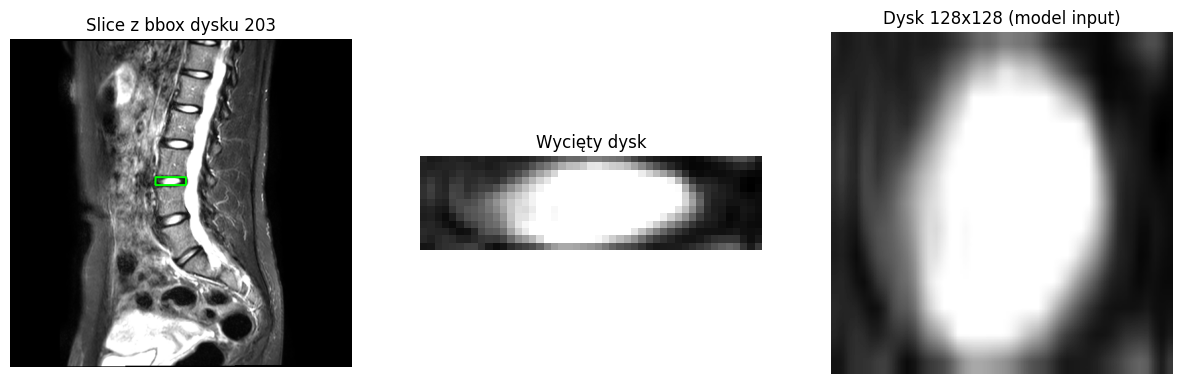

Dysk 204, Pfirrmann grade: BRAK


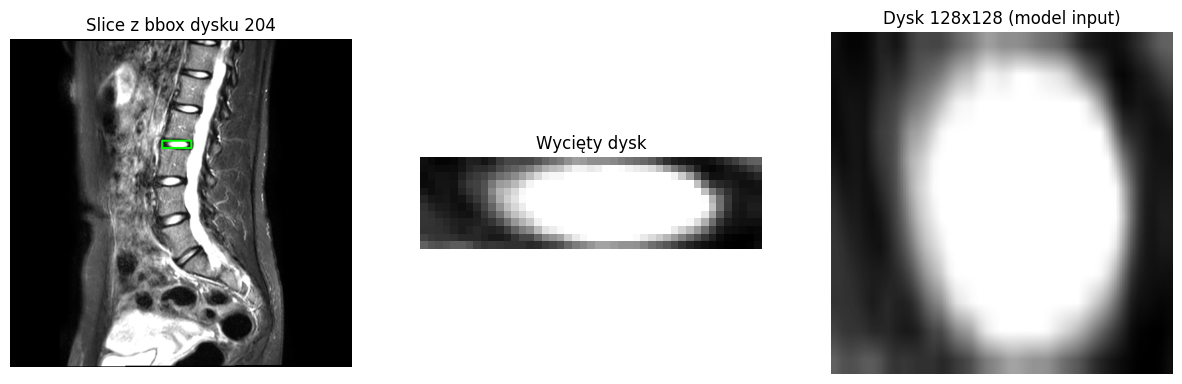

Dysk 205, Pfirrmann grade: BRAK


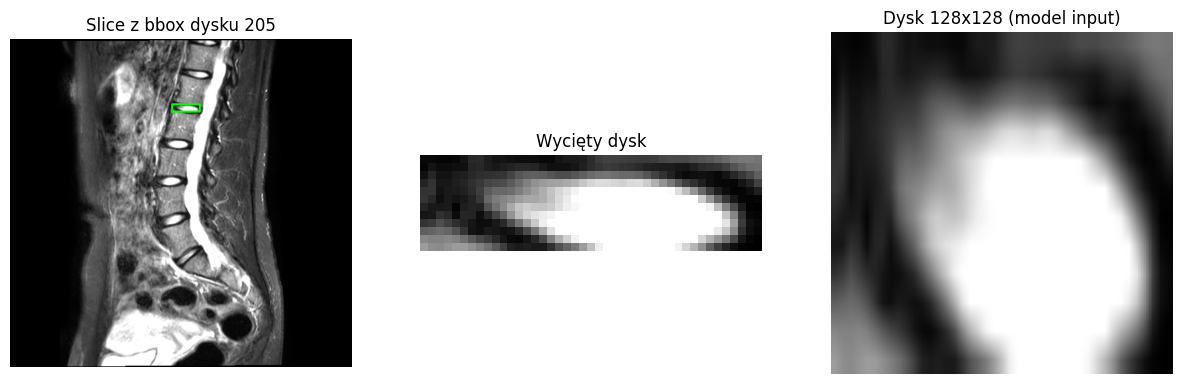

Dysk 206, Pfirrmann grade: BRAK


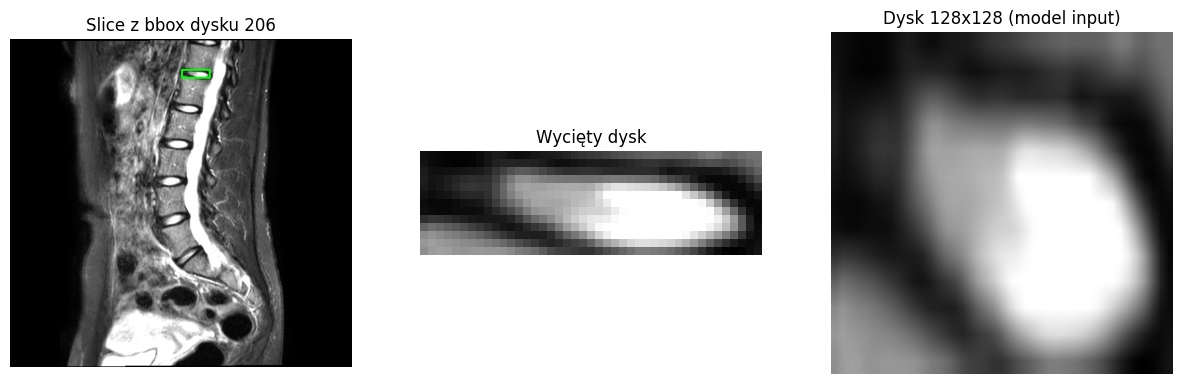

In [61]:
mid = arr_img.shape[2] // 2
slices_to_take = [mid-1, mid, mid+1]

for s_idx in slices_to_take:
    img_slice = np.flipud(arr_img[:, :, s_idx])
    mask_slice = np.flipud(arr_mask[:, :, s_idx])
    
    print(f"\n--- Slice {s_idx} ---")

    for disc_id in np.unique(mask_slice):
        if disc_id < 200:  # ignorujemy tło
            continue

        grade = pfirrman_map.get((patient_id, int(disc_id)), "BRAK")
        print(f"Dysk {disc_id}, Pfirrmann grade: {grade}")

        show_disc(img_slice, mask_slice, disc_id)


In [25]:
np.unique(mask_slice)

array([  0,   1,   2,   3,   4,   5,   6, 100, 201, 202, 203, 204, 205, 206], dtype=int16)

In [52]:
def process_disc(img_slice, mask_slice, disc_id, size=128):
    """
    Wycina dysk z maski, normalizuje i zmienia rozmiar na size x size
    """
    ys, xs = np.where(mask_slice == disc_id)
    if len(xs) == 0:
        return None

    x_min, x_max = xs.min(), xs.max()
    y_min, y_max = ys.min(), ys.max()

    disc_crop = img_slice[y_min:y_max+1, x_min:x_max+1]

    # normalizacja tak, jak w normalize_to_jpg
    img_min, img_max = disc_crop.min(), disc_crop.max()
    if img_max == img_min:
        disc_crop = np.zeros_like(disc_crop, dtype=np.uint8)
    else:
        disc_crop = 255.0 * (disc_crop - img_min) / (img_max - img_min)
        disc_crop = disc_crop.astype(np.uint8)

    # resize
    disc_crop = cv2.resize(disc_crop, (size, size))
    return disc_crop


In [56]:
patient_id = 237
img_path = f"../images/{patient_id}_t2.mha"
mask_path = f"../masks/{patient_id}_t2.mha"

sitk_img = sitk.ReadImage(img_path)
sitk_mask = sitk.ReadImage(mask_path)

arr_img = sitk.GetArrayFromImage(sitk_img)
arr_mask = sitk.GetArrayFromImage(sitk_mask)

mid = arr_img.shape[2] // 2
slices_to_take = [mid-1, mid, mid+1]

processed_discs = []

for s_idx in slices_to_take:
    img_slice = np.flipud(arr_img[:, :, s_idx])
    mask_slice = np.flipud(arr_mask[:, :, s_idx])

    for disc_id in np.unique(mask_slice):
        if disc_id < 200:
            continue

        grade = pfirrman_map.get((patient_id, int(disc_id)), None)
        if grade is None:
            continue

        disc_crop = process_disc(img_slice, mask_slice, disc_id, size=128)
        if disc_crop is not None:
            processed_discs.append((disc_id, grade, disc_crop))


In [54]:
import matplotlib.pyplot as plt

for disc_id, grade, disc_img in processed_discs:
    plt.figure(figsize=(3,3))
    plt.title(f"Dysk {disc_id}, Pfirrmann grade {grade}")
    plt.imshow(disc_img, cmap='gray')
    plt.axis('off')
    plt.show()


In [59]:
slices_to_take

[8, 9, 10]